# Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import sklearn
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plot

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


2024-04-17 18:02:29.827018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 18:02:29.827132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 18:02:29.980666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading and Preprocessing the Data

The following code loads the dataset, cleans the data, and applies preprocesing. The output is a set of features 'x' that is ready for training, along with all the missing values imputed 'y'.

In [2]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')


def _df(data):
    df = pd.DataFrame(data)
    for cell in range(df.shape[1]):
        mapping = {df.columns[cell]: cell}
        df = df.rename(columns=mapping)
    return df

X = (data.drop(columns=["Outcome"])).values
y = (data["Outcome"]).values


X = KNNImputer().fit_transform(X)
data = _df(sklearn.preprocessing.StandardScaler().fit_transform(np.column_stack((X, y))))

# Build the Model

This Gan class handles both the generator and discriminator parts of the GAN. I initially started out with just 100 epochs to make sure everything worked correctly. Later on, I increased the number of epochs to 200 to hopefully yield some better results. The noise generator seeks to generate some random noise in the same shape as the input data in order to produce some new instances.

The generator then learns to create data similar to the inputted noise data. The architecture includes dense layers and utilizes the relu activation function. The linear output layer matches the data dimensions.

The discriminator, opposite to the generator, aims to distinguish between actual data from the dataset and synthetic data produced by the generator. The sigmoid activation function of the output layer classifies the output as either real or fake.

These two components are combined the in _GAN model for training. During training, the discriminator's weights are frozen to ensure the generator learns to improve its synthetic data. Furthermore, while training the discriminator, training alternates between the real data and the synthetic data to hopefully fool the discriminator.

In [3]:
# Derived from (Emami, 2023)
class Gan():
    def __init__(self, data):
        self.data = data
        self.n_epochs = 200

    # Generate random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
            
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('Epoch: %d, Discriminator Loss = %.3f, Generator Loss = %.3f' %(epoch+1, d_loss, g_loss))

        return generator

# Train the Generator and Discriminator

With the robust GAN class set up previously, the generator and discriminator can now be trained on the Pima Indians Diabetes Dataset. It realized it is important to log the loss of both the discriminator and generator, and this should be done separately to compare them. Tracking the loss of the generator will show how well the generator is learning to produce new data, while the discriminator's loss will show how well real and fake data is being distinguished.

In [4]:
model = Gan(data=data)
generator = model._generator()
descriminator = model._discriminator()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
trained_model = model.train(
    generator=generator, discriminator=descriminator, gan=gan_model)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


I0000 00:00:1713376964.806214      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713376964.820565      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713376966.735249      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch: 1, Discriminator Loss = 0.778, Generator Loss = 0.890
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


W0000 00:00:1713376970.014926      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch: 2, Discriminator Loss = 0.770, Generator Loss = 0.860
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 3, Discriminator Loss = 0.762, Generator Loss = 0.836
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 4, Discriminator Loss = 0.757, Generator Loss = 0.812
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 5, Discriminator Loss = 0.753, Generator Loss = 0.789
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 6, Discriminator Loss = 0.750, Generator Loss = 0.768
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 7, Discriminator Loss = 0.747, Generator Loss = 0.751
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 8, Discriminator Loss = 0.743, Generator Loss = 0.733
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 9, Discriminator Loss = 0.740, Generator Loss = 0.718
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 10, Discriminator Loss = 0.738, Generator Loss = 0.704
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch: 11, Discriminator Loss = 0.736, Generator Loss = 0.692
24/24 ━━━━━━━━━━━━━━━━━━━━ 0

Monitoring the losses of the generator vs. the discriminator is of paramount importance when it comes to GANs. If the discriminator's loss gets too low, it may be an indicator that the generator is not learning effectively. Conversely, the generator's loss getting too low may indicate that the discriminator is being successfully fooled. Either of these cases may require tuning to achieve the desired outcome.

In my case, after raising the number of epochs to 200, my final discriminator's loss was about 1.669 and the final generator loss was 0.124. This indicates that the discriminator is being successfully fooled.

# Generate Data

In order to generate some data that is as realistic as possible, it is first necessary to add some noise. Then, the noise vector can be fed as input to the generator to generate some synthetic data instances that resemble the original data.

In [5]:
noise = np.random.normal(0, 1, data.shape) 
new_data = _df(data=trained_model.predict(noise))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Display and Evaluate Data

With the GAN trained and the synthetic data generated, the synthetic data can now be displayed. First, just a few samples to get a feel for the data:

In [6]:
# Display some of the generated data
print("Synthetic Data Samples:")
print(new_data.head())

Synthetic Data Samples:
          0         1         2         3         4         5         6  \
0 -3.653162  0.425714 -2.278464 -1.587666 -5.935311  2.444449  5.846507   
1 -4.767306 -0.819657 -1.782459 -2.626343 -6.762083  2.956857  6.247360   
2 -5.397658 -1.724677 -0.611014 -3.611746 -7.279074  3.540548  5.531808   
3 -5.833370 -1.489655 -0.643647 -4.021646 -8.358809  4.210168  7.743304   
4 -7.392035 -1.935755 -1.601761 -4.491144 -8.502138  4.584846  7.392941   

          7         8  
0  1.520755  5.358426  
1  2.005258  5.767192  
2  1.085099  6.316467  
3  2.749765  7.305337  
4  2.732257  8.357984  


Now, the real data can be compared to the synthetic data visually through a histogram graph.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


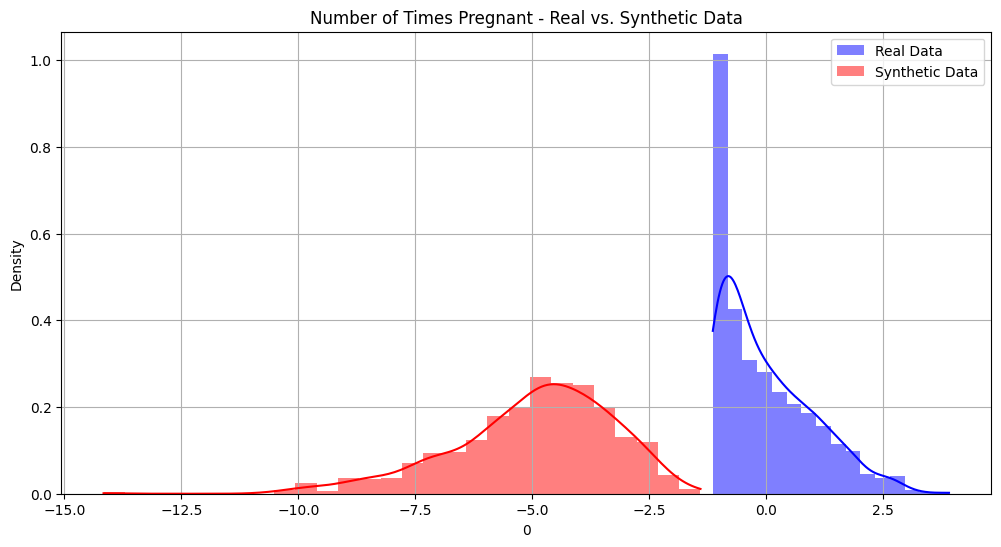

In [7]:
# Function to plot data comparisons
def plot_data(real_data, generated_data, column):
    plot.figure(figsize=(12, 6))
    
    sns.histplot(real_data[column], color="blue", kde=True, stat="density", linewidth=0, label="Real Data")
    sns.histplot(generated_data[column], color="red", kde=True, stat="density", linewidth=0, label="Synthetic Data")
    
    plot.title(f'Number of Times Pregnant - Real vs. Synthetic Data')
    plot.legend()
    plot.grid(True)
    plot.show()

# Plotting distributions for the first feature
plot_data(data, new_data, data.columns[0])


The synthetic data does not make much sense. The first column of the data deals with the number of pregnancies among the Pima Indians, so there would never be negative numbers. The first time I plotted my histogram, my distributions looked much different and my synthetic data actually made sense, though it could have been closer to the real data. I changed the names of a few labels for the graphs (nothing else was changed) and ran everything again and got completely different results containing negative values.

# References

Emami, S. (2023, February 2). Gan-on Tabular Data. Kaggle. https://www.kaggle.com/code/samanemami/gan-on-tabular-data 


Smith, J. W., Everhart, J. E., Knowler, W. C., & Johannes, R. S. (1998). Pima Indians Diabetes Database. Kaggle. https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database 